In [1]:
!pip install networkx
!pip install python-louvain
!pip install matplotlib
!pip install xlrd
!pip install scipy

Note: you may need to restart the kernel to use updated packages.


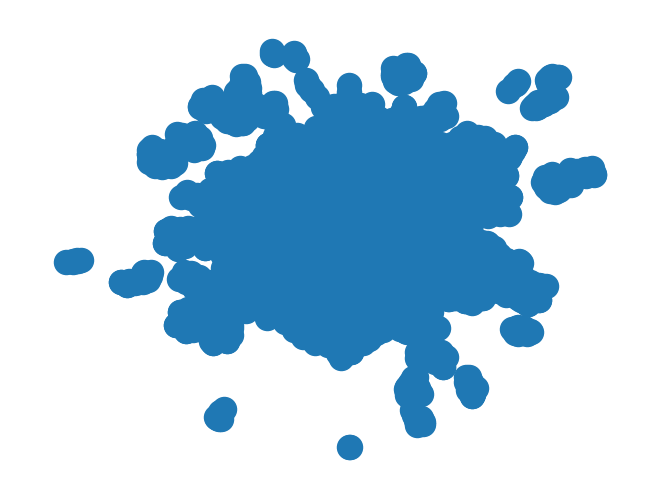

<Figure size 640x480 with 0 Axes>

In [5]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
import xlrd

file ="C:\\Users\\Toshiba\\ijaz\\Book1.xls"


G=nx.Graph()

names=[]

book= xlrd.open_workbook(file)

sheet = book.sheet_by_index(0)

for row in range(sheet.nrows):
    data = sheet.row_slice(row)
    
    person1 = data[0].value
    person2 = data[1].value
    
    names.append((person1, person2))

G.add_edges_from(names)

nx.draw(G)
plt.show()
plt.savefig("abcdef.png")


In [6]:
file ="C:\\Users\\Toshiba\\ijaz\\26359800.xls"

In [7]:
import pandas as pd
# file_path = 'path_for_your_input_excel_sheet'
df = pd.read_excel(file)

In [8]:
blankIndex=[''] * len(df)
df.index=blankIndex
df.to_dict('records')
if df['Unnamed: 0']=='# FromNodeId':
    df1=df.drop(1,axis=0,inplace=True)

KeyError: 'Unnamed: 0'

In [9]:
df1=df.to_dict('records')

In [10]:
"""
Label propagation community detection algorithms.
"""
from collections import Counter, defaultdict

import networkx as nx
from networkx.utils import groups, not_implemented_for, py_random_state

__all__ = ["label_propagation_communities", "asyn_lpa_communities"]


# [docs]
@py_random_state(2)
def asyn_lpa_communities(G, weight=None, seed=None):
    """Returns communities in `G` as detected by asynchronous label
    propagation.

    The asynchronous label propagation algorithm is described in
    [1]_. The algorithm is probabilistic and the found communities may
    vary on different executions.

    The algorithm proceeds as follows. After initializing each node with
    a unique label, the algorithm repeatedly sets the label of a node to
    be the label that appears most frequently among that nodes
    neighbors. The algorithm halts when each node has the label that
    appears most frequently among its neighbors. The algorithm is
    asynchronous because each node is updated without waiting for
    updates on the remaining nodes.

    This generalized version of the algorithm in [1]_ accepts edge
    weights.

    Parameters
    ----------
    G : Graph

    weight : string
        The edge attribute representing the weight of an edge.
        If None, each edge is assumed to have weight one. In this
        algorithm, the weight of an edge is used in determining the
        frequency with which a label appears among the neighbors of a
        node: a higher weight means the label appears more often.

    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    communities : iterable
        Iterable of communities given as sets of nodes.

    Notes
    -----
    Edge weight attributes must be numerical.

    References
    ----------
    .. [1] Raghavan, Usha Nandini, Réka Albert, and Soundar Kumara. "Near
           linear time algorithm to detect community structures in large-scale
           networks." Physical Review E 76.3 (2007): 036106.
    """

    labels = {n: i for i, n in enumerate(G)}
    cont = True

    while cont:
        cont = False
        nodes = list(G)
        seed.shuffle(nodes)

        for node in nodes:
            if not G[node]:
                continue

            # Get label frequencies among adjacent nodes.
            # Depending on the order they are processed in,
            # some nodes will be in iteration t and others in t-1,
            # making the algorithm asynchronous.
            if weight is None:
                # initialising a Counter from an iterator of labels is
                # faster for getting unweighted label frequencies
                label_freq = Counter(map(labels.get, G[node]))
            else:
                # updating a defaultdict is substantially faster
                # for getting weighted label frequencies
                label_freq = defaultdict(float)
                for _, v, wt in G.edges(node, data=weight, default=1):
                    label_freq[labels[v]] += wt

            # Get the labels that appear with maximum frequency.
            max_freq = max(label_freq.values())
            best_labels = [
                label for label, freq in label_freq.items() if freq == max_freq
            ]

            # If the node does not have one of the maximum frequency labels,
            # randomly choose one of them and update the node's label.
            # Continue the iteration as long as at least one node
            # doesn't have a maximum frequency label.
            if labels[node] not in best_labels:
                labels[node] = seed.choice(best_labels)
                cont = True

    yield from groups(labels).values()



# [docs]
@not_implemented_for("directed")
def label_propagation_communities(G):
    """Generates community sets determined by label propagation

    Finds communities in `G` using a semi-synchronous label propagation
    method [1]_. This method combines the advantages of both the synchronous
    and asynchronous models. Not implemented for directed graphs.

    Parameters
    ----------
    G : graph
        An undirected NetworkX graph.

    Returns
    -------
    communities : iterable
        A dict_values object that contains a set of nodes for each community.

    Raises
    ------
    NetworkXNotImplemented
       If the graph is directed

    References
    ----------
    .. [1] Cordasco, G., & Gargano, L. (2010, December). Community detection
       via semi-synchronous label propagation algorithms. In Business
       Applications of Social Network Analysis (BASNA), 2010 IEEE International
       Workshop on (pp. 1-8). IEEE.
    """
    coloring = _color_network(G)
    # Create a unique label for each node in the graph
    labeling = {v: k for k, v in enumerate(G)}
    while not _labeling_complete(labeling, G):
        # Update the labels of every node with the same color.
        for color, nodes in coloring.items():
            for n in nodes:
                _update_label(n, labeling, G)

    clusters = defaultdict(set)
    for node, label in labeling.items():
        clusters[label].add(node)
    return clusters.values()



def _color_network(G):
    """Colors the network so that neighboring nodes all have distinct colors.

    Returns a dict keyed by color to a set of nodes with that color.
    """
    coloring = {}  # color => set(node)
    colors = nx.coloring.greedy_color(G)
    for node, color in colors.items():
        if color in coloring:
            coloring[color].add(node)
        else:
            coloring[color] = {node}
    return coloring


def _labeling_complete(labeling, G):
    """Determines whether or not LPA is done.

    Label propagation is complete when all nodes have a label that is
    in the set of highest frequency labels amongst its neighbors.

    Nodes with no neighbors are considered complete.
    """
    return all(
        labeling[v] in _most_frequent_labels(v, labeling, G) for v in G if len(G[v]) > 0
    )


def _most_frequent_labels(node, labeling, G):
    """Returns a set of all labels with maximum frequency in `labeling`.

    Input `labeling` should be a dict keyed by node to labels.
    """
    if not G[node]:
        # Nodes with no neighbors are themselves a community and are labeled
        # accordingly, hence the immediate if statement.
        return {labeling[node]}

    # Compute the frequencies of all neighbours of node
    freqs = Counter(labeling[q] for q in G[node])
    max_freq = max(freqs.values())
    return {label for label, freq in freqs.items() if freq == max_freq}


def _update_label(node, labeling, G):
    """Updates the label of a node using the Prec-Max tie breaking algorithm

    The algorithm is explained in: 'Community Detection via Semi-Synchronous
    Label Propagation Algorithms' Cordasco and Gargano, 2011
    """
    high_labels = _most_frequent_labels(node, labeling, G)
    if len(high_labels) == 1:
        labeling[node] = high_labels.pop()
    elif len(high_labels) > 1:
        # Prec-Max
        if labeling[node] not in high_labels:
            labeling[node] = max(high_labels)
            
            
# # importing networkx
# import networkx as nx
# # importing matplotlib.pyplot
# import matplotlib.pyplot as plt
# import xlrd

# file ="C:\\Users\\Toshiba\\ijaz\\Book1.xls"


# G=nx.Graph()

# names=[]

# book= xlrd.open_workbook(file)

# sheet = book.sheet_by_index(0)

# for row in range(sheet.nrows):
#     data = sheet.row_slice(row)
    
#     person1 = data[0].value
#     person2 = data[1].value
    
#     names.append((person1, person2))

# G.add_edges_from(names)

# nx.draw(G)
# plt.show()
# plt.savefig("abcdef.png")

label_propagation_communities(df1)

AttributeError: 'list' object has no attribute 'is_directed'

In [11]:
# !pip install pandas xlrd networkx
#

import pandas as pd
import networkx as nx

# Load the dataset
df = pd.read_excel(file)

# Create a NetworkX graph
G = nx.from_pandas_edgelist(df, source='# FromNodeId', target='ToNodeId')

# Calculate and print the centrality measures
centrality_measures = nx.degree_centrality(G)
print("Degree Centrality:", centrality_measures)

# Implement other centrality measures here...


Degree Centrality: {0: 0.000642811227769445, 1: 0.000642811227769445, 2: 0.00042854081851296334, 469: 0.000642811227769445, 6: 0.00042854081851296334, 385: 0.000642811227769445, 3: 0.0008570816370259267, 380: 0.000642811227769445, 37415: 0.00042854081851296334, 5: 0.000642811227769445, 384: 0.000642811227769445, 386: 0.0008570816370259267, 4: 0.0008570816370259267, 419: 0.000642811227769445, 422: 0.0008570816370259267, 98: 0.0008570816370259267, 420: 0.000642811227769445, 35698: 0.0008570816370259267, 183: 0.0008570816370259267, 423: 0.000642811227769445, 470: 0.0008570816370259267, 35729: 0.000642811227769445, 35709: 0.000642811227769445, 7: 0.000642811227769445, 8: 0.00042854081851296334, 9: 0.000642811227769445, 79: 0.000642811227769445, 33: 0.000642811227769445, 10: 0.0008570816370259267, 84: 0.0008570816370259267, 78: 0.000642811227769445, 119: 0.0008570816370259267, 32: 0.000642811227769445, 34: 0.00021427040925648167, 11: 0.000642811227769445, 110: 0.0008570816370259267, 83: 0.0

In [12]:
import pandas as pd
import networkx as nx

# Load the dataset
df = pd.read_excel(file)

# Create a NetworkX graph
G = nx.from_pandas_edgelist(df, source='# FromNodeId', target='ToNodeId')

# Calculate and print the centrality measures
centrality_measures = nx.betweenness_centrality(G)
print("Betweenness Centrality:", centrality_measures)

Betweenness Centrality: {0: 0.003500984114309419, 1: 0.004781314711634111, 2: 0.0004965503713181913, 469: 0.002837683194172608, 6: 0.001082078631013767, 385: 0.005677178249324518, 3: 0.0010067608490150002, 380: 0.0026204798770295946, 37415: 9.763953989024562e-05, 5: 0.0009794692436681856, 384: 0.0010670651437422489, 386: 0.007240710445647212, 4: 0.0008121863057947952, 419: 0.00021625593469441922, 422: 0.000865053257887477, 98: 0.0008860219740768032, 420: 0.0002075825402587398, 35698: 0.00022193794007679927, 183: 0.0024676747206557326, 423: 0.00017367000968456395, 470: 0.0005152629432190538, 35729: 0.00024780972071678756, 35709: 0.00014323727351175363, 7: 0.013523365344262642, 8: 0.012280730843483228, 9: 0.0030340725401271315, 79: 0.011837206584565243, 33: 0.012347122602024125, 10: 0.002565719248650769, 84: 0.00042799175739223765, 78: 0.009585768733439123, 119: 0.003256270348640728, 32: 0.01972170662037042, 34: 0.0, 11: 0.0023156025379523536, 110: 0.0002634117821883429, 83: 0.0003102034

In [21]:
df = pd.DataFrame(list(centrality_measures.items()), columns=['Key', 'Value'])

# Display the DataFrame
df.to_excel('output_1.xlsx')

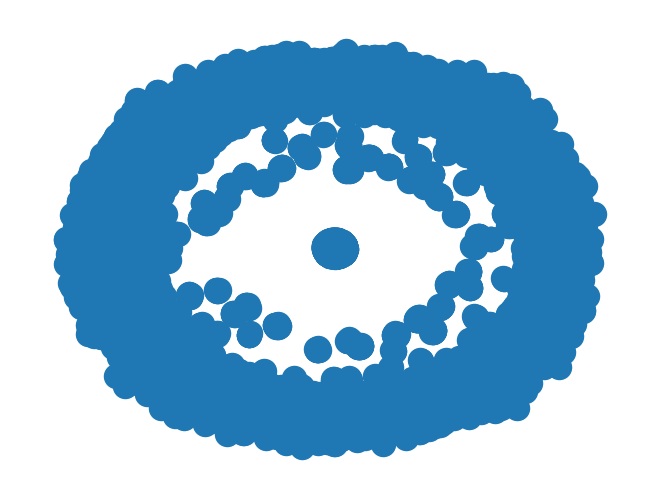

<Figure size 640x480 with 0 Axes>

In [22]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
import xlrd

file ="C:\\Users\\Toshiba\\ijaz\\output_1.xls"


G=nx.Graph()

names=[]

book= xlrd.open_workbook(file)

sheet = book.sheet_by_index(0)

for row in range(sheet.nrows):
    data = sheet.row_slice(row)
    
    person1 = data[0].value
    person2 = data[1].value
    
    names.append((person1, person2))

G.add_edges_from(names)

nx.draw(G)
plt.show()
plt.savefig("abcdef.png")


In [29]:
import networkx as nx
import community

# Create a graph
G = nx.Graph()

# Add nodes and edges to the graph

threshold=0
# Add nodes to the graph
G.add_nodes_from(centrality_measures.keys())

# Add edges to the graph
for node1, value1 in centrality_measures.items():
    for node2, value2 in centrality_measures.items():
        if node1 != node2:
            # Add an edge if the values meet a certain condition
            if value1 > threshold and value2 > threshold:
                G.add_edge(node1, node2)

# Find communities using Louvain method
communities = community.best_partition(G)

# max_community=max(bridge_rank, key=centrality.get)
# max_community
# Print the communities
for node, community_id in communities.items():
    print(f"Node {node} belongs to community {community_id}")

Node 0 belongs to community 494
Node 1 belongs to community 494
Node 2 belongs to community 494
Node 469 belongs to community 494
Node 6 belongs to community 494
Node 385 belongs to community 494
Node 3 belongs to community 494
Node 380 belongs to community 494
Node 37415 belongs to community 494
Node 5 belongs to community 494
Node 384 belongs to community 494
Node 386 belongs to community 494
Node 4 belongs to community 494
Node 419 belongs to community 494
Node 422 belongs to community 494
Node 98 belongs to community 494
Node 420 belongs to community 494
Node 35698 belongs to community 494
Node 183 belongs to community 494
Node 423 belongs to community 494
Node 470 belongs to community 494
Node 35729 belongs to community 494
Node 35709 belongs to community 494
Node 7 belongs to community 494
Node 8 belongs to community 494
Node 9 belongs to community 494
Node 79 belongs to community 494
Node 33 belongs to community 494
Node 10 belongs to community 494
Node 84 belongs to community 4

In [ ]:
import pandas as pd
import networkx as nx

# Load the dataset
df = pd.read_excel(file)

# Create a NetworkX graph
G = nx.from_pandas_edgelist(df, source='# FromNodeId', target='ToNodeId')

# Calculate the k-shell decomposition
core_numbers = nx.core_number(G)

# Calculate and print the k-shell centrality
k_shell_centrality = {}
for node, core_number in core_numbers.items():
    k_shell_centrality[node] = core_number


# Calculate the k-shell decomposition
core_numbers = nx.core_number(G)

# Calculate and print the k-shell centrality
k_shell_centrality = {}
for node, core_number in core_numbers.items():
    k_shell_centrality[node] = core_number
print("K-Shell Centrality:", k_shell_centrality)print("K-Shell Centrality:", k_shell_centrality)

In [ ]:
import pandas as pd
import networkx as nx

# Load the dataset
df = pd.read_excel(file)

# Create a NetworkX graph
G = nx.from_pandas_edgelist(df, source='# FromNodeId', target='ToNodeId')

# Calculate and print the eigenvector centrality
centrality_measures = nx.eigenvector_centrality(G, max_iter=1000)  # Increase max_iter value
print("Eigenvector Centrality:", centrality_measures)

# Implement other centrality measures here...

In [ ]:
import pandas as pd
import networkx as nx

# Load the dataset
df = pd.read_excel(file)

# Create a NetworkX graph
G = nx.from_pandas_edgelist(df, source='# FromNodeId', target='ToNodeId')


# Calculate and print the local centrality (degree centrality)
centrality_measures = nx.degree_centrality(G)
print("Local Centrality (Degree Centrality):", centrality_measures)

In [ ]:
pip install scikit-learn

In [ ]:
pip install openpyxl

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.stats import pearsonr

# Define the Google Sheets URL
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ429n70xf017iXTPfMKrNwbBHJk17nxeTMkLZX-m3J4c9g9YbBqFtfOjQWQTBl1eQocbU7DGAQKT0_/pub?output=xlsx'

# Load the dataset
df = pd.read_excel(url)

# Get the actual labels and predicted labels
actual_labels = df['Actual Labels']
predicted_labels = df['Predicted Labels']

# Calculate the confusion matrix
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion_matrix)

# Calculate the correlation coefficient of the confusion matrix
corr_coefficient, _ = pearsonr(confusion_matrix.flatten(), confusion_matrix.transpose().flatten())
print("Correlation Coefficient:", corr_coefficient)

In [14]:
a={'one':1,'two':2}
pd.json_normalize(a)

,one,two
0,1,2
